In [104]:
%run ../utils_rf.py
import csv

In [105]:
#read training data
file = "../../tables/model_input/noc_answers.csv"
x, x_agg, y, y_agg, x_noclvl, y_noclvl = data_proccess(file,True)

#grab just the noc codes to cut out test nocs from main noc table
train_nocs = pd.read_csv(file,usecols=['noc_code']).drop_duplicates()

In [106]:
y_noclvl.to_csv(r'../../tables/model_output/train_occupation_probs.csv'
                 ,index=True,header=True)

In [107]:
#read full noc set
file ="../../tables/model_input/noc_scores.csv"
nocs = pd.read_csv(file,index_col=['noc'])
nocs.sort_index(inplace=True)
nocs.drop(['Unnamed: 0'],axis=1,inplace=True)
nocs = np.round(nocs).astype(int)
nocs.drop(train_nocs['noc_code'],inplace=True)

*Test using Chosen Model in this script before full training and prediction*

Also I should make the feature be read from a file

In [108]:
f = open('../../tables/SFFS_output/inc_features.txt', 'r')
sffs_prob_features = f.readlines()
f.close()

sffs_prob_features = [x[:-1] for x in sffs_prob_features]

In [109]:
#run 10 times to get an average error rate
means = []
models = []
for i in range(10):    
    inc_prob_sfs = run_k_fold(x.loc[:,sffs_prob_features],y['increase'],init_params('cat'),x.index,True,'pred_probs')
    means.append(abs(inc_prob_sfs.subtract(y_noclvl['increase'],axis=0)).mean())
    models.append(inc_prob_sfs)

In [110]:
inc_prob_sfs = models[np.argmin(means)].copy()

In [111]:
np.mean(means)

0.12541005898984137

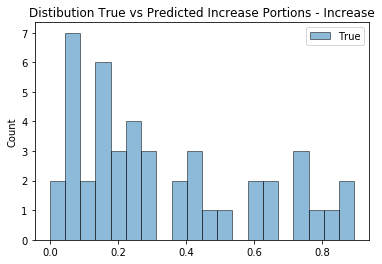

In [112]:
bins=np.histogram(np.hstack((y_noclvl['increase'],inc_prob_sfs[0])), bins=20)[1]#switch to y_agg if doing workshop lvl

fig, ax = plt.subplots()
plt.hist(y_noclvl['increase'],bins, alpha = 0.5, edgecolor = 'black',label='True')
#plt.hist(inc_prob_sfs[0],bins, alpha = 0.25, edgecolor = 'black',label='Pred')
plt.legend(loc='upper right')
ax.set_ylabel('Count')
ax.set_title('Distibution True vs Predicted Increase Portions - Increase')

plt.savefig('../../tables/testing_output/true vs pred error.png')
plt.show()

In [113]:
inc_prob_sfs.to_csv('../../tables/testing_output/inc_trainset_projections.csv')

In [114]:
inc_prob_confusion = confusion_matrix(inc_prob_sfs[0],y_noclvl['increase'],True)
inc_prob_confusion

,pred_increase,pred_decrease
true_increase,7,5
true_decrease,1,32


In [115]:
correct_sum = 0
for i in range(2):
    correct_sum+=inc_prob_confusion.iloc[i,i]
correct_sum/45

0.8666666666666667

In [116]:
inc_prob_confusion = confusion_matrix(inc_prob_sfs[0],y_noclvl['increase'],3)
inc_prob_confusion

,pred>=0.7,0.5<=pred<0.7,0.3<=pred<0.5,pred<0.3
truth>=0.7,0,2,4,1
0.5<=truth<0.7,0,5,0,0
0.3<=truth<0.5,0,1,4,3
truth<0.3,0,0,5,20


In [117]:
correct_sum = 0
for i in range(4):
    correct_sum+=inc_prob_confusion.iloc[i,i]
correct_sum/45

0.6444444444444445

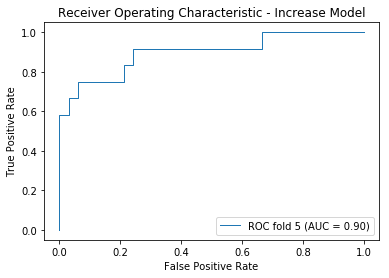

In [118]:
true_labels = y_noclvl['increase'].where(y_noclvl['increase']>=0.5,0).where(y_noclvl['increase']<0.5,1)
fpr, tpr, thresholds = roc_curve(true_labels,inc_prob_sfs[0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1,label='ROC fold %d (AUC = %0.2f)' % (5, roc_auc))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Increase Model')
plt.legend(loc="lower right")
plt.savefig('../../tables/testing_output/roc.png')
plt.show()

In [119]:
np.savetxt("../../tables/testing_output/inc_fpr.csv", fpr, delimiter=",")
np.savetxt("../../tables/testing_output/inc_tpr.csv", tpr, delimiter=",")

Next we will see what this model is bad at predicting

In [120]:
#need to fix this
inc_prob_sfs_acc = abs(inc_prob_sfs.subtract(y_noclvl['increase'],axis=0))
inc_prob_sfs_acc.rename(columns={0: "abs_error"},inplace=True)
inc_prob_sfs_acc['true'] = y_noclvl['increase']
inc_prob_sfs_acc['pred'] = inc_prob_sfs
inc_prob_sfs_acc.sort_values('abs_error',ascending=False,inplace=True)

In [121]:
#the highest absolute error
inc_prob_sfs_acc[0:10]

,,abs_error,true,pred
noc,noc_code,,,
Light duty cleaners,6731,0.542506,0.733333,NaN
Chefs,6321,0.425140,0.894737,NaN
Airline ticket and service agents,6523,0.416688,0.050000,NaN
Graphic designers and illustrators,5241,0.415725,0.894737,NaN
Technical sales specialists - wholesale trade,6221,0.379214,0.739130,NaN
Cooks,6322,0.332645,0.733333,NaN
Carpenters,7271,0.281667,0.450000,NaN
"Health policy researchers, consultants and program officers",4165,0.240479,0.782609,NaN
"Oil and gas well drillers, servicers, testers and related workers",8232,0.213660,0.047619,NaN


In [122]:
#what is wrong as a classifier
inc_prob_sfs_acc.loc[np.logical_or(
    np.logical_and(inc_prob_sfs_acc.true>=0.5,inc_prob_sfs_acc.pred<0.5),
    np.logical_and(inc_prob_sfs_acc.true<0.5,inc_prob_sfs_acc.pred>=0.5))]

,,abs_error,true,pred
noc,noc_code,,,


Next we train on the whole training set

In [123]:
nocs = nocs.loc[:,sffs_prob_features].copy()

rf = RandomForestClassifier(**init_params('cat'))
rf.fit(x.loc[:,sffs_prob_features],y['increase'])
noc_preds = pd.Series(rf.predict_proba(nocs)[:,0],index=nocs.index)

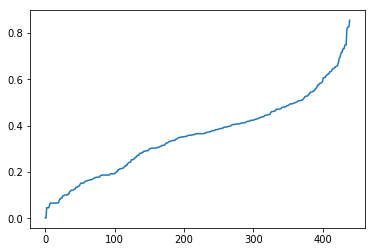

In [124]:
plt.plot(np.sort(noc_preds))
plt.show()

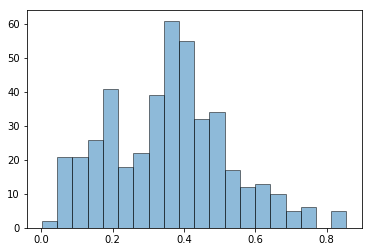

In [125]:
plt.hist(np.sort(noc_preds),20, alpha = 0.5, edgecolor = 'black')
plt.show()

In [126]:
print(sum(noc_preds>=0.7)/noc_preds.shape[0])
print(sum(np.logical_and(noc_preds>=0.5,noc_preds<0.7))/noc_preds.shape[0])
print(sum(np.logical_and(noc_preds>=0.3,noc_preds<0.5))/noc_preds.shape[0])
print(sum(noc_preds<0.3)/noc_preds.shape[0])

0.031818181818181815
0.14772727272727273
0.4772727272727273
0.3431818181818182


In [127]:
print(sum(y_noclvl['increase']>=0.7)/y_noclvl['increase'].shape[0])
print(sum(np.logical_and(y_noclvl['increase']>=0.5,y_noclvl['increase']<0.7))/y_noclvl['increase'].shape[0])
print(sum(np.logical_and(y_noclvl['increase']>=0.3,y_noclvl['increase']<0.5))/y_noclvl['increase'].shape[0])
print(sum(y_noclvl['increase']<0.3)/y_noclvl['increase'].shape[0])

0.15555555555555556
0.1111111111111111
0.17777777777777778
0.5555555555555556


ok now for some robustness we will run the model 10 times and see if there is a signifiant difference in predictions and ordering of nocs

In [128]:
robust_check = pd.DataFrame()

for i in range(10):
    rf = RandomForestClassifier(**init_params('cat'))
    rf.fit(x.loc[:,sffs_prob_features],y['increase'])
    robust_check[i] = pd.Series(rf.predict_proba(nocs.loc[:,sffs_prob_features])[:,0],index=nocs.index)

In [129]:
diffs = []

for i in range(10):
    for j in range(i+1,10):
            diffs.append(abs(robust_check[i]-robust_check[j]))

diffs = pd.DataFrame(diffs).T

In [130]:
diffs.mean(axis = 1).max()

0.028123742224047732

In [131]:
diffs.mean(axis = 1).mean()

0.012801559281807944

In [132]:
diffs.mean(axis = 1).std()

0.006167376759758777

In [133]:
rank_diffs = []

robust_check_ranks = robust_check.rank(axis=0)

for i in range(10):
    for j in range(i+1,10):
        rank_diffs.append(abs(robust_check_ranks[i]-robust_check_ranks[j]))

rank_diffs = pd.DataFrame(rank_diffs).T        

In [134]:
rank_diffs.mean(axis=1).mean()

10.284090909090907

In [135]:
rank_diffs.mean(axis=1).std()

7.187448476777346

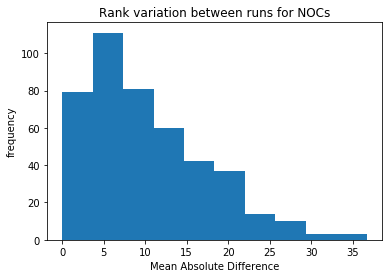

In [137]:
plt.hist(rank_diffs.mean(axis=1))
plt.title('Rank variation between runs for NOCs')
plt.xlabel('Mean Absolute Difference')
plt.ylabel('frequency')
plt.savefig('../../tables/testing_output/rank variation across runs')
plt.show()